In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer
import random
import collections
%matplotlib inline

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Adatelőkészítés

In [2]:
df = pd.read_csv('data/DataSet_LakasArak.csv')

In [3]:
del df['ad_view_cnt']
del df['active_days']
del df['nr']

In [4]:
random.seed(8594726138)
columns = list(df.columns)
random.shuffle(columns)
df = df[columns]
df

,elevator_type,county,room_cnt,view_type,balcony_area,garden_access,created_at,small_room_cnt,orientation,property_type,postcode,property_area,building_floor_count,city,property_condition_type,property_subtype,heating_type,property_floor,price_created_at
0,yes,Budapest,2.0,street view,0.0,NaN,2015-02-09,1.0,NaN,flat,NaN,65.0,NaN,Budapest XII.,good,brick flat (for sale),tile stove (gas),1,23.5
1,yes,Budapest,1.0,street view,0.0,NaN,2015-02-09,1.0,NaN,flat,1016.0,45.0,NaN,Budapest I.,novel,brick flat (for sale),konvection gas burner,2,20.0
2,yes,Budapest,2.0,garden view,0.0,NaN,2015-02-09,1.0,NaN,flat,1164.0,60.0,NaN,Budapest XVI.,novel,brick flat (for sale),central heating with own meter,1,22.0
3,none,Budapest,2.0,garden view,4.0,NaN,2015-02-09,0.0,NaN,flat,NaN,55.0,NaN,Budapest X.,good,brick flat (for sale),central heating,4,11.0
4,yes,Budapest,2.0,NaN,3.0,NaN,2015-02-09,1.0,NaN,flat,1181.0,60.0,NaN,Budapest XVIII.,renewed,prefabricated panel flat (for sale),NaN,6,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78534,none,Budapest,2.0,NaN,0.0,NaN,2016-08-29,0.0,south,flat,1063.0,65.0,NaN,Budapest VI.,to_be_renovated,brick flat (for sale),"gas furnace, circulating hot water",1,29.9
78535,yes,Budapest,1.0,NaN,0.0,NaN,2016-08-29,0.0,NaN,flat,1031.0,35.0,NaN,Budapest III.,missing_info,prefabricated panel flat (for sale),NaN,NaN,12.9
78536,none,Budapest,1.0,NaN,0.0,NaN,2016-08-29,0.0,NaN,flat,NaN,25.0,NaN,Budapest XIV.,good,brick flat (for sale),konvection gas burner,ground floor,9.0
78537,none,Budapest,1.0,NaN,0.0,NaN,2016-08-29,1.0,east,flat,1024.0,40.0,NaN,Budapest II.,novel,brick flat (for sale),"gas furnace, circulating hot water",basement,17.5


In [5]:
df.columns

Index(['elevator_type', 'county', 'room_cnt', 'view_type', 'balcony_area',
       'garden_access', 'created_at', 'small_room_cnt', 'orientation',
       'property_type', 'postcode', 'property_area', 'building_floor_count',
       'city', 'property_condition_type', 'property_subtype', 'heating_type',
       'property_floor', 'price_created_at'],
      dtype='object')

In [6]:
df.isna().sum()

elevator_type              14151
county                         0
room_cnt                       0
view_type                  35661
balcony_area                   0
garden_access              61339
created_at                     0
small_room_cnt                 0
orientation                30892
property_type                  0
postcode                   28954
property_area                  0
building_floor_count       42110
city                         559
property_condition_type        0
property_subtype            1659
heating_type               11306
property_floor              3793
price_created_at               0
dtype: int64

Ennek a módszernek célja az idő dimenzió, és ezzel esetleges trend eliminálása a négyzetméterárból. Órán volt szó arról, hogy az adathalmaz születésének időszakában az ingatlanpiac erősödött, így aki irreálisan magas árat választott, azt a piac előbb-utóbb utolérte. Ez a jelenség rontja a modellünk általánosítóképességét, ezért a hagyományos négyzetméterár helyett egy jelenértékre számított négyzetméterárat számítok ki az órán tanult módon. Ez az érték minden ingatlanra az adathalmaz utolsó napjához arányosít.

In [7]:
# jelenértékű nmÁr
df['nmAr'] = df['price_created_at']*1000000/df['property_area']
df['datum'] = pd.to_datetime(df['created_at'])
stat = df.groupby('datum', as_index=False).agg({"nmAr":"median"})
df['daynum'] = (df['datum'] - df['datum'].min()).dt.days
stat['daynum'] = (stat['datum'] - stat['datum'].min()).dt.days
minlinreg = LinearRegression()
minlinreg.fit(stat[ ['daynum'] ], stat['nmAr'])
stat['trend_nmAr']= minlinreg.predict(stat[['daynum']])
del stat['nmAr']
del stat['daynum']
df = df.merge(stat, on='datum', how='left')
df['jelen_nmAr']= df['nmAr']/df['trend_nmAr']* stat['trend_nmAr'].max()
df

,elevator_type,county,room_cnt,view_type,balcony_area,garden_access,created_at,small_room_cnt,orientation,property_type,...,property_condition_type,property_subtype,heating_type,property_floor,price_created_at,nmAr,datum,daynum,trend_nmAr,jelen_nmAr
0,yes,Budapest,2.0,street view,0.0,NaN,2015-02-09,1.0,NaN,flat,...,good,brick flat (for sale),tile stove (gas),1,23.5,361538.461538,2015-02-09,0,311324.872196,527579.077640
1,yes,Budapest,1.0,street view,0.0,NaN,2015-02-09,1.0,NaN,flat,...,novel,brick flat (for sale),konvection gas burner,2,20.0,444444.444444,2015-02-09,0,311324.872196,648560.568257
2,yes,Budapest,2.0,garden view,0.0,NaN,2015-02-09,1.0,NaN,flat,...,novel,brick flat (for sale),central heating with own meter,1,22.0,366666.666667,2015-02-09,0,311324.872196,535062.468812
3,none,Budapest,2.0,garden view,4.0,NaN,2015-02-09,0.0,NaN,flat,...,good,brick flat (for sale),central heating,4,11.0,200000.000000,2015-02-09,0,311324.872196,291852.255716
4,yes,Budapest,2.0,NaN,3.0,NaN,2015-02-09,1.0,NaN,flat,...,renewed,prefabricated panel flat (for sale),NaN,6,10.2,170000.000000,2015-02-09,0,311324.872196,248074.417358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78534,none,Budapest,2.0,NaN,0.0,NaN,2016-08-29,0.0,south,flat,...,to_be_renovated,brick flat (for sale),"gas furnace, circulating hot water",1,29.9,460000.000000,2016-08-29,567,454304.331054,460000.000000
78535,yes,Budapest,1.0,NaN,0.0,NaN,2016-08-29,0.0,NaN,flat,...,missing_info,prefabricated panel flat (for sale),NaN,NaN,12.9,368571.428571,2016-08-29,567,454304.331054,368571.428571
78536,none,Budapest,1.0,NaN,0.0,NaN,2016-08-29,0.0,NaN,flat,...,good,brick flat (for sale),konvection gas burner,ground floor,9.0,360000.000000,2016-08-29,567,454304.331054,360000.000000
78537,none,Budapest,1.0,NaN,0.0,NaN,2016-08-29,1.0,east,flat,...,novel,brick flat (for sale),"gas furnace, circulating hot water",basement,17.5,437500.000000,2016-08-29,567,454304.331054,437500.000000


## Transzformációs függvények oszlopsorrendben

In [8]:
def tr_elevator_type(df, input_cols):
    df['elevator_type']=df['elevator_type'].apply(lambda x: 1 if str(x)[0]=='y' else 0)
    input_cols += ['elevator_type']
    return df, input_cols

def tr_county(df, input_cols):
    #nem rakom bele mert minden érték azonos
    return df, input_cols
    
def tr_room_cnt(df, input_cols):
    input_cols += ['room_cnt']
    return df, input_cols
    
def tr_view_type(df, input_cols):
    # dummy
    view_dummies = pd.get_dummies(df['view_type'], prefix = 'view_type=', drop_first = True)
    df = df.merge(view_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(view_dummies.columns)
    return df, input_cols
    
def tr_balcony_area(df, input_cols):
    input_cols += ['balcony_area']
    return df, input_cols
    
def tr_garden_access(df, input_cols):
    # dummy
    garden_access_dummies = pd.get_dummies(df['garden_access'], prefix = 'garden_access=', drop_first = True)
    df = df.merge(garden_access_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(garden_access_dummies.columns)
    return df, input_cols
    
def tr_created_at(df, input_cols):
    df['created_at'] = pd.to_datetime(df['created_at'])
    cr_min = df['created_at'].min()
    df['created_at'] = (df['created_at'] - cr_min).dt.days
    input_cols += ['created_at']
    return df, input_cols
    
def tr_small_room_cnt(df, input_cols):
    input_cols += ['small_room_cnt']
    return df, input_cols
    
def tr_orientation_1(df, input_cols):
    # dummy
    orientation_dummies = pd.get_dummies(df['orientation'], prefix = 'orientation=', drop_first = True)
    df = df.merge(orientation_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(orientation_dummies.columns)
    return df, input_cols
    
def tr_orientation_2(df, input_cols):
    # adott?
    df['orientation_given'] = df['orientation'].apply(lambda x: 0 if x==NaN else 1)
    input_cols += ['orientation_given']
    return df, input_cols
    
def tr_property_type(df, input_cols):
    # nem rakom bele mert minden érték azonos
    return df, input_cols
    
def tr_postcode_1(df, input_cols):
    df['postcode'] = df['postcode'].fillna(1000)
    input_cols += ['postcode']
    return df, input_cols
    
def tr_postcode_2(df, input_cols):
    df['postcode'] = df['postcode'].fillna(1000)
    df['postcode'].apply(lambda x: x % 1000)
    input_cols += ['postcode']
    return df, input_cols
    
def tr_property_area(df, input_cols):
    input_cols += ['property_area']
    return df, input_cols
    
def tr_building_floor_count(df, input_cols):
    df['building_floor_count'] = df['building_floor_count'].fillna('other')
    df['building_floor_count'] = df['building_floor_count'].apply(lambda x: 11 if str(x)[0]=='m' else (0 if str(x)[0]=='o' else x))
    input_cols += ['building_floor_count']
    return df, input_cols
    
def tr_city_1(df, input_cols):
    # kerület dummy
    city_dummies = pd.get_dummies(df['city'], prefix = 'city=', drop_first = True)
    df = df.merge(city_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(city_dummies.columns)
    return df, input_cols
    
def tr_city_2(df, input_cols):
    # Buda (0), Pest(1) vagy Csepel (2)?
    mapping = {
        0:2, 1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1,
        11:0, 12:0, 13:1, 14:1, 15:1, 16:1, 17:1, 18:1, 19:1, 20:1,
        21:2, 22:0, 23:1
    }
    df['ker_code']=df['postcode'].fillna(1000).apply(lambda x: int(str(x)[1:3]))
    stat = df.groupby('city',as_index=False).agg({'ker_code':'max'}) 
    stat.iloc[9,1]=10
    stat.iloc[12,1]=13
    stat.columns=['city','kerulet_sorszam']
    df=df.merge(stat,on='city',how='left')
    df['kerulet_sorszam']=df['kerulet_sorszam'].fillna(0)
    df['kerulet_csoport']=df['kerulet_sorszam'].apply(lambda x: mapping[x])
    input_cols += ['kerulet_csoport']
    return df, input_cols
    
def tr_city_3(df, input_cols):
    # egyszerű számérték irányítószámból és kerületnevekből
    df['ker_code']=df['postcode'].fillna(1000).apply(lambda x: int(str(x)[1:3]))
    stat = df.groupby('city',as_index=False).agg({'ker_code':'max'}) 
    stat.iloc[9,1]=10
    stat.iloc[12,1]=13
    stat.columns=['city','kerulet_sorszam']
    df=df.merge(stat,on='city',how='left')
    df['kerulet_sorszam']=df['kerulet_sorszam'].fillna(0)
    input_cols += ['kerulet_sorszam']
    return df, input_cols
    
def tr_property_condition_type1(df, input_cols):
    # dummy
    property_condition_type_dummies = pd.get_dummies(df['property_condition_type'], prefix = 'property_condition_type=', drop_first = True)
    df = df.merge(property_condition_type_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(property_condition_type_dummies.columns)
    return df, input_cols
    
def tr_property_condition_type2(df, input_cols):
    mapping = {
        'new_construction': 5,
        'good': 4,
        'novel': 3,
        'renewed': 2,
        'medium': 1,
        'missing_info': 0,
        'under_construction': -1,
        'can_move_in': -2,
        'to_be_renovated': -3
    }
    df['property_condition_type'] = df['property_condition_type'].apply(lambda x: mapping[x])
    input_cols += ['property_condition_type']
    return df, input_cols
    
def tr_property_subtype(df, input_cols):
    # dummy
    property_subtype_dummies = pd.get_dummies(df['property_subtype'], prefix = 'property_subtype=', drop_first = True)
    df = df.merge(property_subtype_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(property_subtype_dummies.columns)
    return df, input_cols
    
def tr_heating_type_1(df, input_cols):
    # dummy
    df['heating_type']=df['heating_type'].fillna('other')
    heating_dummies = pd.get_dummies(df['heating_type'], prefix = 'heating_type=', drop_first = True)
    df = df.merge(heating_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(heating_dummies.columns)
    return df, input_cols
    
def tr_heating_type_2(df, input_cols):
    # mapping gyakoriság alapján
    mapping = {
        'gas furnace':10,
        'fan-coil':9,
        'tile stove (gas)':8,
        'electric':7,
        'central heating':6,
        'central heating with own meter':5,
        'other':4,
        'district heating':3,
        'gas furnace, circulating hot water':2,
        'konvection gas burner':1
    }
    df['heating_type']=df['heating_type'].fillna('other')
    df['heating_num']=df['heating_type'].apply(lambda x: mapping[x])
    input_cols += ['heating_num']
    return df, input_cols
    
def prop_floor(x):
    if x == 'ground floor':
        return 0
    if x == 'mezzanine floor':
        return 0.5
    if x == '10 plus':
        return 11
    if x == 'basement':
        return -1
    return x   

def tr_property_floor_1(df, input_cols):
    df['property_floor'] = df['property_floor'].fillna(0).apply(lambda x: prop_floor(x))
    input_cols += ['property_floor']
    return df, input_cols

    
def tr_property_floor_2(df, input_cols):
    # dummy
    property_floor_dummies = pd.get_dummies(df['property_floor'], prefix = 'property_floor=', drop_first = True)
    df = df.merge(property_floor_dummies, left_index = True, right_index = True, how = 'left')
    input_cols += list(property_floor_dummies.columns)
    return df, input_cols

def tr_price_created_at(df, input_cols):
    # ez felesleges, ebből lett a származtatott jelen_nmAr célváltozó
    
    return df, input_cols
    
def tr_which_day_1(df, input_cols):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['day_of_week'] = df['created_at'].apply(lambda x: x.weekday())
    input_cols += ['day_of_week']
    return df, input_cols
    
def tr_which_day_2(df, input_cols):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['day_of_week'] = df['created_at'].apply(lambda x: x.weekday())
    df['day_of_week'] = df['day_of_week'].apply(lambda x: 1 if x == 5 or x == 6 else 0)
    input_cols += ['day_of_week']
    return df, input_cols


In [9]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better = False)

In [10]:
score_lin = []
score_gbm = []
score_neu = []

def learn_step(step_index, df, bemenok, kimeno):
    linreg = LinearRegression()
    gbm = GradientBoostingRegressor(random_state=42, max_depth=5, n_estimators=100)
    neural = MLPRegressor(learning_rate='adaptive', random_state=42, hidden_layer_sizes=(10, 10, 10,), early_stopping=True, max_iter=200)
    
    g_lin = GridSearchCV(estimator=linreg, param_grid={}, cv=3, scoring=mape_scorer, verbose=1)
    g_lin.fit(df[bemenok], df[kimeno])
    score_lin.append( [step_index, len(bemenok), g_lin.cv_results_['mean_test_score'][0] ] )
    
    g_gbm = GridSearchCV(estimator=gbm, param_grid={}, cv=3, scoring=mape_scorer, verbose=1)
    g_gbm.fit(df[bemenok], df[kimeno])
    score_gbm.append( [step_index, len(bemenok), g_gbm.cv_results_['mean_test_score'][0] ] )

    g_neu = GridSearchCV(estimator=neural, param_grid={}, cv=3, scoring=mape_scorer, verbose=3)
    g_neu.fit(df[bemenok], df[kimeno])
    score_neu.append( [step_index, len(bemenok), g_neu.cv_results_['mean_test_score'][0] ] )
    
    return g_lin.cv_results_['mean_test_score'][0], g_gbm.cv_results_['mean_test_score'][0], g_neu.cv_results_['mean_test_score'][0]

## Oszlopok egyenkénti hozzáadása és tanítások:

In [11]:
bemenok = []
kimeno = 'jelen_nmAr'


# 1 elevator_type
print('# 1 elevator_type START')
df, bemenok = tr_elevator_type(df, bemenok)
print(bemenok)
learn_step(1, df, bemenok, kimeno)
print('# 1 elevator_type END')

# 2 county
print('# 2 county START')
df, bemenok = tr_county(df, bemenok)
learn_step(2, df, bemenok, kimeno)
print('# 2 county END')

# 3 room_cnt
print('# 3 room_cnt START')
df, bemenok = tr_room_cnt(df, bemenok)
learn_step(3, df, bemenok, kimeno)
print('# 3 room_cnt END')

# 4 view_type
print('# 4 view_type START')
df, bemenok = tr_view_type(df, bemenok)
learn_step(4, df, bemenok, kimeno)
print('# 4 view_type END')

# 5 balcony_area
print('# 5 balcony_area START')
df, bemenok = tr_balcony_area(df, bemenok)
learn_step(5, df, bemenok, kimeno)
print('# 5 balcony_area END')

# 6 garden_access
print('# 6 garden_access START')
df, bemenok = tr_garden_access(df, bemenok)
learn_step(6, df, bemenok, kimeno)
print('# 6 garden_access END')


df_created_at_1 = df.copy()
df_created_at_2 = df.copy()
bem1 = bemenok.copy()
bem2 = bemenok.copy()
# 7 created_at 1
print('# 7 created_at => which_day 1 START')
df_created_at_1, bem1 = tr_which_day_1(df_created_at_1, bem1)
_,__, res1 = learn_step(7, df_created_at_1, bem1, kimeno)
print('# 7 created_at => which_day 1 END')

# 7 created_at 2
print('# 7 created_at => which_day 2 START')
df_created_at_2, bem2 = tr_which_day_2(df_created_at_2, bem2)
_,__, res2 = learn_step(7, df_created_at_2, bem2, kimeno)
print('# 7 created_at => which_day 2 END')
if (res1 > res2):
    df = df_created_at_1
    bemenok = bem1
else:
    df = df_created_at_2
    bemenok = bem2


# 8 small_room_cnt
print('# 8 small_room_cnt START')
df, bemenok = tr_small_room_cnt(df, bemenok)
learn_step(8, df, bemenok, kimeno)
print('# 8 small_room_cnt END')


df_orientation_1 = df.copy()
df_orientation_2 = df.copy()
bem1 = bemenok.copy()
bem2 = bemenok.copy()
# 9 orientation 1
print('# 9 orientation 1 START')
df_orientation_1, bem1 = tr_which_day_1(df_orientation_1, bem1)
_,__, res1 = learn_step(9, df_orientation_1, bem1, kimeno)
print('# 9 orientation 1 END')

# 9 orientation 2
print('# 9 orientation 2 START')
df_orientation_2, bem2 = tr_which_day_2(df_orientation_2, bem2)
_,__, res2 = learn_step(9, df_orientation_2, bem2, kimeno)
print('# 9 orientation 2 END')
if (res1 > res2):
    df = df_orientation_1
    bemenok = bem1
else:
    df = df_orientation_2
    bemenok = bem2


# 10 property_type
print('# 10 property_type START')
df, bemenok = tr_property_type(df, bemenok)
learn_step(10, df, bemenok, kimeno)
print('# 10 property_type END')


df_postcode_1 = df.copy()
df_postcode_2 = df.copy()
bem1 = bemenok.copy()
bem2 = bemenok.copy()
# 11 postcode 1
print('# 11 postcode 1 START')
df_postcode_1, bem1 = tr_postcode_1(df_postcode_1, bem1)
_,__, res1 = learn_step(11, df_postcode_1, bem1, kimeno)
print('# 11 postcode 1 END')

# 11 postcode 2
print('# 11 postcode 2 START')
df_postcode_2, bem2 = tr_postcode_2(df_postcode_2, bem2)
_,__, res2 = learn_step(11, df_postcode_2, bem2, kimeno)
print('# 11 postcode 2 END')
if (res1 > res2):
    df = df_postcode_1
    bemenok = bem1
else:
    df = df_postcode_2
    bemenok = bem2

# 12 property_area
print('# 12 property_area START')
df, bemenok = tr_property_area(df, bemenok)
learn_step(12, df, bemenok, kimeno)
print('# 12 property_area END')

# 13 building_floor_count
print('# 13 building_floor_count START')
df, bemenok = tr_building_floor_count(df, bemenok)
learn_step(13, df, bemenok, kimeno)
print('# 13 building_floor_count END')


df_city_1 = df.copy()
df_city_2 = df.copy()
df_city_3 = df.copy()
bem1 = bemenok.copy()
bem2 = bemenok.copy()
bem3 = bemenok.copy()
# 14 city 1
print('# 14 city 1 START')
df_city_1, bem1 = tr_city_1(df_city_1, bem1)
_,__, res1 = learn_step(14, df_city_1, bem1, kimeno)
print('# 14 city 1 END')

# 14 city 2
print('# 14 city 2 START')
df_city_2, bem2 = tr_city_2(df_city_2, bem2)
_,__, res2 = learn_step(14, df_city_2, bem2, kimeno)
print('# 14 city 2 END')

# 14 city 3
print('# 14 city 3 START')
df_city_3, bem3 = tr_city_2(df_city_3, bem3)
_,__, res3 = learn_step(14, df_city_3, bem3, kimeno)
print('# 14 city 3 END')
if (res1 > res2):
    if(res1 > res3):
        df = df_city_1
        bemenok = bem1
elif (res2 > res3):
    df = df_city_2
    bemenok = bem2
else:
    df = df_city_3
    bemenok = bem3


df_pct_1 = df.copy()
df_pct_2 = df.copy()
bem1 = bemenok.copy()
bem2 = bemenok.copy()
# 15 property_condition_type 1
print('# 15 property_condition_type 1 START')
df_pct_1, bem1 = tr_property_condition_type1(df_pct_1, bem1)
_,__, res1 = learn_step(15, df_pct_1, bem1, kimeno)
print('# 15 property_condition_type 1 END')

# 15 property_condition_type 2
print('# 15 property_condition_type 2 START')
df_pct_2, bem2 = tr_property_condition_type2(df_pct_2, bem2)
_,__, res2 = learn_step(15, df_pct_2, bem2, kimeno)
print('# 15 property_condition_type 2 END')
if (res1 > res2):
    df = df_pct_1
    bemenok = bem1
else:
    df = df_pct_2
    bemenok = bem2

# 16 property_subtype
print('# 16 property_subtype START')
df, bemenok = tr_property_subtype(df, bemenok)
learn_step(16, df, bemenok, kimeno)
print('# 16 property_subtype END')


df_heating_1 = df.copy()
df_heating_2 = df.copy()
bem1 = bemenok.copy()
bem2 = bemenok.copy()
# 17 heating_type 1
print('# 17 heating_type 1 START')
df_heating_1, bem1 = tr_heating_type_1(df_heating_1, bem1)
_,__, res1 = learn_step(17, df_heating_1, bem1, kimeno)
print('# 17 heating_type 1 END')

# 17 heating_type 2
print('# 17 heating_type 2 START')
df_heating_2, bem2 = tr_heating_type_2(df_heating_2, bem2)
_,__, res2 = learn_step(17, df_heating_2, bem2, kimeno)
print('# 17 heating_type 2 END')
if (res1 > res2):
    df = df_heating_1
    bemenok = bem1
else:
    df = df_heating_2
    bemenok = bem2

# 18 property_floor
df_pfloor_1 = df.copy()
df_pfloor_2 = df.copy()
bem1 = bemenok.copy()
bem2 = bemenok.copy()
# 18 property_floor 1
print('# 18 property_floor 1 START')
df_pfloor_1, bem1 = tr_property_floor_1(df_pfloor_1, bem1)
_,_, res1 = learn_step(18, df_pfloor_1, bem1, kimeno)
print('# 18 property_floor 1 END')

# 18 property_floor 2
print('# 18 property_floor 2 START')
df_pfloor_2, bem2 = tr_property_floor_2(df_pfloor_2, bem2)
_,_, res2 = learn_step(18, df_pfloor_2, bem2, kimeno)
print('# 18 property_floor 2 END')
if (res1 > res2):
    df = df_pfloor_1
    bemenok = bem1
else:
    df = df_pfloor_2
    bemenok = bem2

# 1 elevator_type START
['elevator_type']
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .................................., score=-0.326 total time=  21.0s
[CV 2/3] END .................................., score=-0.344 total time=  22.7s
[CV 3/3] END .................................., score=-0.326 total time=  28.5s
# 1 elevator_type END
# 2 county START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .................................., score=-0.326 total time=  21.0s
[CV 2/3] END .................................., score=-0.344 total time=  22.7s
[CV 3/3] END .................................., score=-0.326 total time=  28.3s
# 2 county END
# 3 room_cnt START
Fitting 3 folds for each of 1 candidates, tot

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.329 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.337 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.325 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 11 postcode 1 END
# 11 postcode 2 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.329 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.337 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.325 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 11 postcode 2 END
# 12 property_area START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .................................., score=-0.318 total time= 1.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.336 total time= 1.2min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.319 total time= 1.2min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 12 property_area END
# 13 building_floor_count START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.322 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.329 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.310 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 13 building_floor_count END
# 14 city 1 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.222 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.212 total time= 1.6min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.204 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 14 city 1 END
# 14 city 2 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.309 total time= 1.6min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.310 total time= 1.7min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.300 total time= 1.7min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 14 city 2 END
# 14 city 3 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.309 total time= 2.8min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.310 total time= 2.1min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.300 total time= 1.2min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 14 city 3 END
# 15 property_condition_type 1 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.202 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.191 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.186 total time= 1.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 15 property_condition_type 1 END
# 15 property_condition_type 2 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.215 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.207 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.199 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 15 property_condition_type 2 END
# 16 property_subtype START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.182 total time= 3.0min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.174 total time= 2.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.170 total time= 2.6min
# 16 property_subtype END
# 17 heating_type 1 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.183 total time= 2.8min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.177 total time= 2.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.171 total time= 3.0min
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.189 total time= 2.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.188 total time= 2.6min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.175 total time= 2.4min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 17 heating_type 2 END
# 18 property_floor 1 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.186 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.176 total time= 1.3min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.168 total time= 1.5min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 18 property_floor 1 END
# 18 property_floor 2 START
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END .................................., score=-0.177 total time= 1.9min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END .................................., score=-0.177 total time= 1.9min


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END .................................., score=-0.164 total time= 2.7min
# 18 property_floor 2 END


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
def filter_and_find_largest(data):
    grouped_data = collections.defaultdict(list)

    for item in data:
        first_element = item[0]
        third_element = item[2]
        grouped_data[first_element].append((third_element, item))

    filtered_data = []

    for key, group in grouped_data.items():
        max_element = max(group, key=lambda x: x[0])
        filtered_data.append(max_element[1])

    filtered_data.sort(key=lambda x: x[0])

    return filtered_data

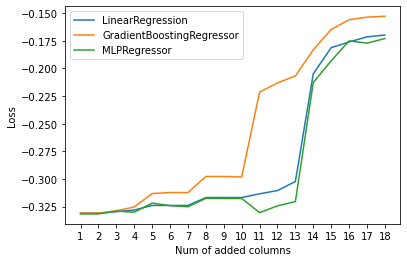

In [17]:
score_lin = filter_and_find_largest(score_lin)
score_gbm = filter_and_find_largest(score_gbm)
score_neu = filter_and_find_largest(score_neu)

with open("score_lin.txt", "w") as file:
    file.write(str(score_lin))

with open("score_gbm.txt", "w") as file:
    file.write(str(score_gbm))

with open("score_neu.txt", "w") as file:
    file.write(str(score_neu))


x_values1 = [point[0] for point in score_lin]
y_values1 = [point[2] for point in score_lin]

x_values2 = [point[0] for point in score_gbm]
y_values2 = [point[2] for point in score_gbm]

x_values3 = [point[0] for point in score_neu]
y_values3 = [point[2] for point in score_neu]

# Create a scatter plot for each dataset
plt.xticks(np.arange(min(x_values1), max(x_values1)+1, 1.0))
plt.plot(x_values1, y_values1, label='LinearRegression', linestyle='-')
plt.plot(x_values2, y_values2, label='GradientBoostingRegressor', linestyle='-')
plt.plot(x_values3, y_values3, label='MLPRegressor', linestyle='-')

# Label the axes
plt.xlabel('Num of added columns')
plt.ylabel('Loss')

plt.legend()
plt.show()

A táblázatban látható a loss-ok alakulása az újabb és újabb oszlopok hozzáadásával, modellenként külön-külön.
A paraméterek hozzáadásával általában nő a modellek pontossága. (Kivétel volt ezazlól az MLPRegressor, ami két esetben is gyengébb eredményt hozott új paraméter hozzáadásakor: irányítószámok, fűtéstípus)

A 11. paraméter hozzáadásával a GradientBoostigRegressor nagyot javult, ez az irányítószámok hozzáadása volt.
A másik két modell a 14. paraméternél, a kerület hozzáadásakor javult sokat.

A legjobban teljesítő modell a GradientBoostigRegressor lett, de a különbségek nem nagyok.

## Végső adatelemzési folyamat

In [27]:
df_final = df.copy()
bemenok_final = bemenok.copy()

In [26]:
pd.set_option('display.max_columns', None)


In [28]:
p_grid = {
    'max_depth': [4,5,6,7],
    'n_estimators': [100, 150, 200]
}
g_final = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42), 
    param_grid=p_grid, 
    cv=3, scoring=mape_scorer, 
    verbose=3
)
g_final.fit(df_final[bemenok_final], df_final[kimeno])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=4, n_estimators=100;, score=-0.165 total time=  18.7s
[CV 2/3] END ....max_depth=4, n_estimators=100;, score=-0.161 total time=  18.0s
[CV 3/3] END ....max_depth=4, n_estimators=100;, score=-0.152 total time=  18.4s
[CV 1/3] END ....max_depth=4, n_estimators=150;, score=-0.158 total time=  25.2s
[CV 2/3] END ....max_depth=4, n_estimators=150;, score=-0.154 total time=  26.3s
[CV 3/3] END ....max_depth=4, n_estimators=150;, score=-0.146 total time=  26.9s
[CV 1/3] END ....max_depth=4, n_estimators=200;, score=-0.155 total time=  35.5s
[CV 2/3] END ....max_depth=4, n_estimators=200;, score=-0.150 total time=  35.4s
[CV 3/3] END ....max_depth=4, n_estimators=200;, score=-0.143 total time=  34.2s
[CV 1/3] END ....max_depth=5, n_estimators=100;, score=-0.160 total time=  21.8s
[CV 2/3] END ....max_depth=5, n_estimators=100;, score=-0.154 total time=  22.5s
[CV 3/3] END ....max_depth=5, n_estimators=100;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=3)

In [39]:
best = g_final.best_estimator_
type(best)
g_final.best_estimator_

GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=42)

A legjobb modell a vizsgáltak közül:
GradientBoostingRegressor(max_depth=7, n_estimators=200, random_state=42)

In [40]:
def kiertekelo_fuggveny(df, tipp_oszlop_neve, target_oszlop_neve):
    mean_absolute_error=   (abs(df[tipp_oszlop_neve]-df[target_oszlop_neve])).mean()
    
    MAPE=(abs((df[target_oszlop_neve] - df[tipp_oszlop_neve])/df[target_oszlop_neve])).mean()
    rmse =  np.sqrt( ( (df[tipp_oszlop_neve]-df[target_oszlop_neve])**2 ).mean() )
    print("RMSE",rmse)
    print("MAE:",mean_absolute_error)
    print("MAPE:",MAPE)
    df["tipp_arany"] = df[target_oszlop_neve]/df[tipp_oszlop_neve]
    erdekesek = df[ (df['tipp_arany']> 0.75) & (df['tipp_arany'] < 0.95)]
    print("Atnezendok aranya", len(erdekesek)/len(df))
    return erdekesek

In [45]:
# A feladat egy olyan gépi tanulási megoldás elkészítése, ami egy ingatlan adathalmazon képes megjeleníteni, hogy mely ingatlanokat érdemes megvizsgálni, hiszen azok a becsült piaci ár alatt vannak 5-25%-kal.

test_df = df.copy()
test_df['tipp']=best.predict(test_df[bemenok_final])
erdekesek = kiertekelo_fuggveny(test_df, 'tipp', 'jelen_nmAr')

df_to_write = pd.read_csv('data/DataSet_LakasArak.csv')
df_to_write = df_to_write.filter(items=erdekesek.index, axis=0)
df_to_write.to_csv('Results_O78UXU.csv', index=False)

RMSE 84395.73240336076
MAE: 55183.947416220566
MAPE: 0.115254033852456
Atnezendok aranya 0.33756477673512525
